In [1]:
import io
import subprocess
import os
import glob
import sys
import pwd

import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.decomposition import PCA
import pickle
import re
import math
import plotnine as pn
import seaborn as sns
import glob
import subprocess
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from numpy import log
from collections import defaultdict,Counter
import re
import statsmodels
import warnings
import statsmodels.stats.multitest as smm
import json

from pathlib import Path
from midas import m
from datetime import datetime, date
import altair as alt

# gh specific
sys.path.append('/ghsfa/projects/pharma/shared_scripts/')
import bibp.functions as functions
import hgvslib.pHGVS as pHGVS  ## do a pull on the hgvslib git repo

# !pip install statannotations==0.4.0
# #!pip uninstall statannotations --yes
# from statannotations.Annotator import Annotator

warnings.filterwarnings("ignore")
pd.options.display.max_rows = None
pd.options.display.max_columns=None
pd.options.display.max_colwidth=None
work_dir="/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024"

# SOW176 TFv2 update (Endometrial Cancer) and MSI/MLH1 distribution

## Data preocessing

In [2]:
# # Readin latest batches (TFv2 updated version by Evan) from Google drive

# df_sow176_ori_1 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176_Infinity/AZN_SOW176_Infinity_01/tb/20240620_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv", header = 0) 
# df_sow176_ori_2 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176Monitoring_Infinity/AZN_SOW176Monitoring_Infinity_01/tb/20240620_AstraZeneca_SOW176_998Samples_TFv2_RevealInfinityReport.csv", header = 0) 
# df_sow176_ori_3 = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176Monitoring_Infinity/AZN_SOW176Monitoring_Infinity_02/tb/20240620_AstraZeneca_SOW176_56Samples_TFv2_RevealInfinityReport.csv", header = 0) 

# # Concatenate the dataframes
# # Important note !!!!! The data structure of df_sow175_ori_1, df_sow175_ori_2 are different. The concatnation is not perfect but it's fine as we handel different reports separately later.
# df_sow176_all = pd.concat([df_sow176_ori_1, df_sow176_ori_2, df_sow176_ori_3], ignore_index=True)

# print("Total sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.shape[0]) + "\n") 
# print("Total unique sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.GHSampleID.nunique()) + "\n")
# print("Total unique patient sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.Patient_ID.nunique()) + "\n")

# df_sow176_all.head()

Total sample size of SOW176 Infinity cumulative batches is 22539

Total unique sample size of SOW176 Infinity cumulative batches is 1406

Total unique patient sample size of SOW176 Infinity cumulative batches is 352



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
1,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,SDHA,5,233698.0,8.0,A334A,G>A,c.1002G>A,NM_004168.4,51.35,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99371911,rs144252500,NaN,NaN,NaN,NaN,2568.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
2,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,BABAM1,19,17389819.0,9.0,E318K,G>A,c.952G>A,NM_001033549.3,51.10,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3918.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
3,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,MYOD1,11,17741548.0,1.0,P73P,G>A,c.219G>A,NM_002478.5,49.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51455670,rs373565128,NaN,NaN,NaN,NaN,1985.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN
4,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1.0,SUCCESS,NaN,SNV,NaN,GEN1,2,17963176.0,14.0,Q899H,G>C,c.2697G>C,NM_182625.5,49.19,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370541992,NaN,NaN,NaN,NaN,2889.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,NaN,NaN,NaN


In [2]:
# Readin latest batches (TFv2 updated version by Evan) from Google drive
# Just need the baseline samples

df_sow176_all = pd.read_csv("/ghsfa/projects/pharma/customers/AstraZeneca/Infinity/AZN_SOW176_Infinity/AZN_SOW176_Infinity_01/tb/20240620_AstraZeneca_SOW176_352Samples_TFv2_InfinityReport.csv", header = 0) 

print("Total sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.shape[0]) + "\n") 
print("Total unique sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.GHSampleID.nunique()) + "\n")
print("Total unique patient sample size of SOW176 Infinity cumulative batches is " + str(df_sow176_all.Patient_ID.nunique()) + "\n")

df_sow176_all.head()

Total sample size of SOW176 Infinity cumulative batches is 21485

Total unique sample size of SOW176 Infinity cumulative batches is 352

Total unique patient sample size of SOW176 Infinity cumulative batches is 352



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
1,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,SDHA,5,233698.0,8.0,A334A,G>A,c.1002G>A,NM_004168.4,51.35,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV99371911,rs144252500,NaN,NaN,NaN,NaN,2568.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
2,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,BABAM1,19,17389819.0,9.0,E318K,G>A,c.952G>A,NM_001033549.3,51.10,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3918.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
3,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,MYOD1,11,17741548.0,1.0,P73P,G>A,c.219G>A,NM_002478.5,49.68,NaN,germline,synonymous,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV51455670,rs373565128,NaN,NaN,NaN,NaN,1985.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
4,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,GEN1,2,17963176.0,14.0,Q899H,G>C,c.2697G>C,NM_182625.5,49.19,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs370541992,NaN,NaN,NaN,NaN,2889.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [3]:
# Remove duplication
df_sow176_dedup = df_sow176_all.drop_duplicates(subset = "GHSampleID")
df_sow176_dedup.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164000,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
46,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.000000,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
73,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.105663,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
207,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000582,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
226,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.047770,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [4]:
df_sow176_dedup.Cancertype.value_counts()

Endometrial Cancer    352
Name: Cancertype, dtype: int64

In [5]:
# Pull "runid" from ghdb
df_sow176_1 = df_sow176_dedup.copy()

# Define the IDs you want to query for
ids = tuple(df_sow176_1['GHSampleID'].unique())

# Generate the SQL query string
query = "SELECT * FROM gh_sample WHERE run_sample_id IN {}".format(ids)

# Get the dataframe with "runid"
sample_df = functions.run_sql_query(query)
sample_df = sample_df.rename(columns={"run_sample_id": "GHSampleID"})

# Found some sample has duplicated runid which might due to re-run. So only the latest FC runs were saved.
# Extract the date from runid and convert to datetime format for accurate comparison
sample_df['run_date'] = pd.to_datetime(sample_df['runid'].str.extract(r'(\d{6})')[0], format='%y%m%d')
df_sow176_1 = df_sow176_1.merge(sample_df[['GHSampleID', 'runid', 'run_date']], on='GHSampleID', how="left")
df_sow176_1 = df_sow176_1.sort_values(by=['GHSampleID', 'run_date'], ascending=[True, False]).drop_duplicates(subset='GHSampleID', keep='first')
df_sow176_1 = df_sow176_1.drop(columns='run_date')

print("Total sample size of SOW176 Infinity cumulative batches after merging runid is " + str(df_sow176_1.shape[0])) 
df_sow176_1.head()


Total sample size of SOW176 Infinity cumulative batches after merging runid is 352


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7
57,D9311C00001,6602928171,A0978707,B00630250,E6009006,C1D1,1,SUCCESS,NaN,SNV,NaN,LRP1B,2,141259369.0,55.0,K2913E,T>C,c.8737A>G,NM_018557.3,51.84,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2365.0,0.24,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,15.548,3.0,0.0,12/05/2023,06/02/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7
69,D9311C00001,6801680163,A0978706,B00630251,E4306005,C1D1,1,SUCCESS,NaN,SNV,NaN,GSTM1,1,110235865.0,8.0,R202H,G>A,c.605G>A,NM_000561.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs371247780,NaN,NaN,NaN,NaN,582.0,12.00,NaN,NaN,Detected,0.095000,33.82,High,Detected,14.612,3.0,0.0,03/01/2024,10/01/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7


In [6]:
def add_fc_dir_column(df):
    """
    Adds a 'fc_dir' column to the given dataframe, specifying the FC path based on the 'runid' column.

    Args:
        df (pd.DataFrame): A DataFrame that must contain a 'runid' column. This column is used to
                           match directory paths from predefined locations.

    Returns:
        pd.DataFrame: The original dataframe with an added 'fc_dir' column indicating the directory path
                      corresponding to each 'runid'. If no directory is found, the path will be an empty string.
        pd.DataFrame: A DataFrame containing the rows for which no directory path was found.
    """
    # Define the path
    fc_dir_all = "/ghsfa/ivd/flowcentral"
    fc_dir_omni = "/ghsfa/projects/omni_v2/flowcells"
    
    # Initialize a list to store rows where no BIP output was found
    rows_no_found = []
    
    # Initialize the new column in the DataFrame
    df['fc_dir'] = ''
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        runid = row["runid"]
        
        # Find original folder
        pattern_ori = f"{fc_dir_all}/*{runid}*"
        folders = glob.glob(pattern_ori)
        if folders:
            df.loc[index, 'fc_dir'] = folders[0]
        else:
            # Search in the alternative directory if no folder found in the first directory
            pattern_omni = f"{fc_dir_omni}/*{runid}*"
            folders_omni = glob.glob(pattern_omni)
            if folders_omni:
                df.loc[index, 'fc_dir'] = folders_omni[0]
            else:
                # Append the row to the list if no folder is found in either location
                rows_no_found.append(row)
    
    # Create a DataFrame with rows where folders were not found in any sources
    df_no_fc_dir = pd.DataFrame(rows_no_found)
    
    return df, df_no_fc_dir

# Generate the new dataframe 
df_sow176_2, df_no_found = add_fc_dir_column(df_sow176_1)

print("Total sample size of SOW176 Infinity cumulative batches with fc_dir is " + str(df_sow176_2.shape[0]) + "\n") 
print("Total sample size of SOW176 Infinity cumulative batches with NO fc_dir is " + str(df_no_found.shape[0]) + "\n") 

df_sow176_2.head()



Total sample size of SOW176 Infinity cumulative batches with fc_dir is 352

Total sample size of SOW176 Infinity cumulative batches with NO fc_dir is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036
57,D9311C00001,6602928171,A0978707,B00630250,E6009006,C1D1,1,SUCCESS,NaN,SNV,NaN,LRP1B,2,141259369.0,55.0,K2913E,T>C,c.8737A>G,NM_018557.3,51.84,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2365.0,0.24,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,15.548,3.0,0.0,12/05/2023,06/02/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036
69,D9311C00001,6801680163,A0978706,B00630251,E4306005,C1D1,1,SUCCESS,NaN,SNV,NaN,GSTM1,1,110235865.0,8.0,R202H,G>A,c.605G>A,NM_000561.4,100.00,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs371247780,NaN,NaN,NaN,NaN,582.0,12.00,NaN,NaN,Detected,0.095000,33.82,High,Detected,14.612,3.0,0.0,03/01/2024,10/01/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036


## Generate Pancancer S3 MB caller and Single region caller outputs for this SOW
#### Notes:
    1. No cancer type provided
###### Git clone Sirius-1.6.0_Release_Branch for region_file and control_file files for different S3 MB callers
###### Branch https://github.com/guardant/bip-products/blob/Sirius-1.6.0_Release_Branch/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml#L653-L680
###### Confluence page to follow: https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update

In [37]:
# # bip-epigenomics module (branch 2.4.5 with Sirius 1.5 single region caller region/control/module files) is prefered.

# def run_bip_epigenomics_module_single_region_wrapper_slurm(sample_meta_df, workdir):
#     module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/epi245/bip-epigenomics/' # branch 2.4.5

#     # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
#     parameter_set_yaml = f"{workdir}/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.5


#     jobs_dir = f"{workdir}/MB_module_SOW176_single_region_jobs"
#     output_dir = f"{workdir}/MB_module_SOW176_single_region_output"

#     # Check and create directories if not exists
#     if not os.path.exists(jobs_dir):
#         os.makedirs(jobs_dir)

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]
#         mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
#         bip_config_json_file = f"{fc_dir}/bip_config.json"
        
#         if not os.path.exists(mbd_hyper_molecules):
#             continue

#         # Make a folder for each run_sample_id
#         output_sample_dir = f"{output_dir}/{run_sample_id}"

#         if not os.path.exists(output_sample_dir):
#             os.makedirs(output_sample_dir)

#         # Copy the bip_config.json for each sample from BIP output. This is essential for module running
#         # (samples in the same batch shared the same bip_config.json)
#         os.system(f"cp {bip_config_json_file} {output_sample_dir}")

#         job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
#         shebang_content = (f"#!/bin/bash\n"
#                            f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
#                            f"#SBATCH --nodes=1\n"
#                            f"#SBATCH --ntasks=1\n"
#                            f"#SBATCH --cpus-per-task=1\n"
#                            f"#SBATCH --mem=60gb\n"
#                            f"#SBATCH --partition=dev\n"
#                            f"#SBATCH --time=01:00:00\n"
#                            f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
#         with open(job_file, "w") as job_output:
#             job_output.write(shebang_content)
#             job_output.write(f"{module_dir}/module_entry single_region_caller " + 
#                              f"--in-hyper-molecules {mbd_hyper_molecules} " + 
#                              f"--sample-id {run_sample_id} " + 
#                              f"--output-dir {output_sample_dir}/ " +
#                              f"--parameter-set {parameter_set_yaml} " + 
#                              f"--threads 4 " + 
#                              f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_single_region_caller.memory.log " +
#                              f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_single_region.log")
#             # print(job_output)    
#         os.system(f"sbatch {job_file}")


In [ ]:
# #run the function to generate all the single region caller ouputs for this sow  
# run_bip_epigenomics_module_single_region_wrapper_slurm(df_sow176_2, 
#                       f"{work_dir}")

In [9]:
# Retrieve MLH1 binary call and MSI status/score

df_sow176_3 = df_sow176_2.copy()

df_sow176_3["MLH1_single_region_call_Sirius1_5"] = np.nan
df_sow176_3["MLH1_single_region_methyl_score_Sirius1_5"] = np.nan
df_sow176_3["MLH1_single_region_molecules_Sirius1_5"] = np.nan
df_sow176_3["MLH1_single_region_file_path_Sirius1_5"] = np.nan


df_sow176_3["MLH1_single_region_call_Sirius1_1_4"] = np.nan
df_sow176_3["MLH1_single_region_methyl_score_Sirius1_1_4"] = np.nan
df_sow176_3["MLH1_single_region_molecules_Sirius1_1_4"] = np.nan
df_sow176_3["MLH1_single_region_file_path_Sirius1_1_4"] = np.nan



df_sow176_3["msi_score"] = np.nan
df_sow176_3["msi_status"] = np.nan
# Add some columns that Shile needs
df_sow176_3["sampleQC"] = np.nan

# df_sow176_3["positive_single_region_PM_gene"] = None  # New column for storing genes with positive calls
# df_sow176_3["PM_detection_percentage"] = np.nan  # New column for storing detection percentage
# df_sow176_3["single_region_call_table_path"] = np.nan 

single_caller_result_folder = f"{work_dir}/MB_module_SOW176_single_region_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow176_3.iterrows():
    fc_dir = crc_row["fc_dir"]
    run_sample_id = crc_row["GHSampleID"]

    #sirius 1.5 and 1.1.4 single region
    single_region_file_1_5 = f"{single_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.single_region_call.hdr.tsv"
    single_region_file_114 = f"{fc_dir}/{run_sample_id}/{run_sample_id}.single_region_call.report.hdr.tsv"

    # Other columns input
    msi_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.msi_call.hdr.tsv"
    sample_qc_file = f"{fc_dir}/{run_sample_id}/{run_sample_id}.autoqc_sample_qc.hdr.tsv"


    try:
        single_df_15 = pd.read_table(single_region_file_1_5)
        single_df_114 = pd.read_table(single_region_file_114)
        msi_df = pd.read_table(msi_file)

        if not single_df_15.empty and not msi_df.empty and not single_df_114.empty:
            mlh1_df = single_df_15[single_df_15['gene'] == 'MLH1']
            if not mlh1_df.empty:
                df_sow176_3.at[index, "MLH1_single_region_call_Sirius1_5"] = mlh1_df.iloc[0]['call']
                df_sow176_3.at[index, "MLH1_single_region_methyl_score_Sirius1_5"] = mlh1_df.iloc[0]['methyl_score']
                df_sow176_3.at[index, "MLH1_single_region_molecules_Sirius1_5"] = mlh1_df.iloc[0]['molecules']

            mlh1_df_114 = single_df_114[single_df_114['gene'] == 'MLH1']
            if not mlh1_df_114.empty:
                df_sow176_3.at[index, "MLH1_single_region_call_Sirius1_1_4"] = mlh1_df_114.iloc[0]['call']
                df_sow176_3.at[index, "MLH1_single_region_methyl_score_Sirius1_1_4"] = mlh1_df_114.iloc[0]['methyl_score']
                df_sow176_3.at[index, "MLH1_single_region_molecules_Sirius1_1_4"] = mlh1_df_114.iloc[0]['molecules']

            # Get MSI
            df_sow176_3.at[index, "msi_score"] = msi_df.loc[0, "msi_score"]
            df_sow176_3.at[index, "msi_status"] = msi_df.loc[0, "msi_status"]

            # Add Shile's requested columns
            df_sow176_3.at[index, "sampleQC"] = sample_qc_file
            df_sow176_3.at[index, "MLH1_single_region_file_path_Sirius1_5"] = single_region_file_1_5
            df_sow176_3.at[index, "MLH1_single_region_file_path_Sirius1_1_4"] = single_region_file_114

            # df_sow176_3.at[index, "sampleQC"] = sample_qc_file

            # # Add the single region file path
            # df_sow176_3.at[index, "single_region_call_table_path"] = msre_mr_file

            # # Check for positive single region PM gene calls and store the gene names
            # positive_genes = msre_df[msre_df['call'] == 1]['gene'].tolist()
            # if positive_genes:
            #     df_sow176_3.at[index, "positive_single_region_PM_gene"] = ', '.join(positive_genes)

            # # Calculate detection percentage
            # total_rows = len(msre_df)
            # positive_calls = len(positive_genes)
            # detection_percentage = (positive_calls / total_rows) * 100 if total_rows > 0 else 0
            # df_sow176_3.at[index, "PM_detection_percentage"] = detection_percentage

        else:
            # Add the index to the list if msre_df or msi_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any exception
        problematic_rows.append(index)  
        print(f"Error processing file {single_region_file_1_5}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow176_3.loc[problematic_rows]

print("Total sample size of SOW176 Infinity cumulative batches with NO MLH1 single region output is " + str(df_problematic.shape[0]) + "\n") 

df_sow176_3.head()


Total sample size of SOW176 Infinity cumulative batches with NO MLH1 single region output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call_Sirius1_5,MLH1_single_region_methyl_score_Sirius1_5,MLH1_single_region_molecules_Sirius1_5,MLH1_single_region_file_path_Sirius1_5,MLH1_single_region_call_Sirius1_1_4,MLH1_single_region_methyl_score_Sirius1_1_4,MLH1_single_region_molecules_Sirius1_1_4,MLH1_single_region_file_path_Sirius1_1_4,msi_score,msi_status,sampleQC
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630247/B00630247/B00630247.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.single_region_call.report.hdr.tsv,2.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.autoqc_sample_qc.hdr.tsv
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630248/B00630248/B00630248.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.single_region_call.report.hdr.tsv,6.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.autoqc_sample_qc.hdr.tsv
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630249/B00630249/B00630249.single_region_call.hdr.tsv,0.0,0.000000,

In [10]:
# Remove the failed samples
df_sow176_success = df_sow176_3[df_sow176_3['Sample_status'] == 'SUCCESS']
print(df_sow176_success.shape)

df_sow176_success.to_csv(f"{work_dir}/df_sow176_success.csv", index = False)

(347, 69)


In [51]:
df_sow176_3.msi_status.value_counts()

MSS/MSI-L    295
MSI-H         52
Name: msi_status, dtype: int64

In [36]:
df_sow176_3.MLH1_single_region_methyl_score.describe()

count    352.000000
mean       0.000855
std        0.004060
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        0.043946
Name: MLH1_single_region_methyl_score, dtype: float64

In [29]:
# df_sow176_3.to_csv(f'{work_dir}/df_sow176_single_region_summary.csv', index = False)

In [26]:
# df_sow176_3.detection_percentage.mean()

2.7046020011547416

In [20]:
# df_sow176_3_test = df_sow176_3[df_sow176_3['GHSampleID'] == 'B00619288']
# df_sow176_3_test

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,Tumor_methylation_status_mapped,MLH1_single_region_call,MLH1_single_region_methyl_score,msi_score,msi_status,positive_single_region_PM_gene


In [ ]:
# # Instead of using epicaller.methylation.methyl_caller funciton, bip-epigenomics module (branch 2.5 with Sirius 1.6 MB caller region/control/module files) is prefered.

# def run_bip_epigenomics_module_wrapper_slurm(sample_meta_df, workdir):
#     module_dir = '/ghsfa/projects/omni_v2/users/chlee/bip4/bip-epigenomics/' # branch 2.5
#     # parameter_set_yaml = "/ghsfa/bik8s/test/bip-portal/outputs/Sirius_LDT_Soft_240905_020053/products/sirius/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6
#     parameter_set_yaml = "/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/bip-products/Sirius_LDT_Soft/Sirius_LDT_Soft.yaml" # branch Sirius 1.6


#     jobs_dir = f"{workdir}/MB_module_SOW176_jobs"
#     output_dir = f"{workdir}/MB_module_SOW176_output"

#     # Check and create directories if not exists
#     if not os.path.exists(jobs_dir):
#         os.makedirs(jobs_dir)

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     for _, row in sample_meta_df.iterrows():
#         run_sample_id = row["GHSampleID"]
#         fc_dir = row["fc_dir"]
#         mbd_hyper_molecules = f"{fc_dir}/{run_sample_id}/{run_sample_id}.mbd_hyper_molecules.tsv"
#         bip_config_json_file = f"{fc_dir}/bip_config.json"
        
#         if not os.path.exists(mbd_hyper_molecules):
#             continue

#         # Make a folder for each run_sample_id
#         output_sample_dir = f"{output_dir}/{run_sample_id}"

#         if not os.path.exists(output_sample_dir):
#             os.makedirs(output_sample_dir)

#         # Copy the bip_config.json for each sample from BIP output. This is essential for module running
#         # (samples in the same batch shared the same bip_config.json)
#         os.system(f"cp {bip_config_json_file} {output_sample_dir}")

#         job_file = f"{jobs_dir}/MB_call_{run_sample_id}.job"
#         shebang_content = (f"#!/bin/bash\n"
#                            f"#SBATCH --job-name=MB_call_{run_sample_id}\n"
#                            f"#SBATCH --nodes=1\n"
#                            f"#SBATCH --ntasks=1\n"
#                            f"#SBATCH --cpus-per-task=1\n"
#                            f"#SBATCH --mem=60gb\n"
#                            f"#SBATCH --partition=dev\n"
#                            f"#SBATCH --time=01:00:00\n"
#                            f"#SBATCH --output={jobs_dir}/MB_call_{run_sample_id}.log\n\n")
        
#         with open(job_file, "w") as job_output:
#             job_output.write(shebang_content)
#             job_output.write(f"{module_dir}/module_entry msre_caller " + 
#                              f"--in-hyper-molecules {mbd_hyper_molecules} " + 
#                              f"--sample-id {run_sample_id} " + 
#                              f"--output-dir {output_sample_dir}/ " +
#                              f"--parameter-set {parameter_set_yaml} " + 
#                              f"--threads 16 " + 
#                              f"--memory-log {output_sample_dir}/{run_sample_id}-epigenomics_msre_caller.memory.log " +
#                              f"--log-file {output_sample_dir}/{run_sample_id}--epigenomics_msre_caller.log")
#             # print(job_output)    
#         os.system(f"sbatch {job_file}")


In [ ]:
# #run the function to generate all the MB S3 caller ouputs for this sow  
# run_bip_epigenomics_module_wrapper_slurm(df_sow176_2, 
#                       f"{work_dir}")

In [17]:
# Retrieve MB S3 Pancancer caller score
# Result is from /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024

df_sow176_3["MB_pancancer_score"] = np.nan

mb_caller_result_folder = f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/MB_module_SOW176_output"
problematic_rows = []  # List to store indices of problematic rows

for index, crc_row in df_sow176_3.iterrows():
    run_sample_id = crc_row["GHSampleID"]
    msre_mr_file = f"{mb_caller_result_folder}/{run_sample_id}/{run_sample_id}/{run_sample_id}.msre_pancancer_call.hdr.tsv"

    try:
        msre_df = pd.read_table(msre_mr_file)

        if not msre_df.empty:
            df_sow176_3.at[index, "MB_pancancer_score"] = msre_df.loc[0, "methyl_score"]

        else:
            # Add the index to the list if msre_df is empty
            problematic_rows.append(index) 
            
    except Exception as e:
        # Add the index to the list if there is any other exception
        problematic_rows.append(index)  
        print(f"Error processing file {msre_mr_file}: {str(e)}")

# Create a DataFrame with the indices of the problematic rows
df_problematic = df_sow176_3.loc[problematic_rows]

print("Total sample size of SOW176 Infinity cumulative batches with NO MB output is " + str(df_problematic.shape[0]) + "\n") 

# Returning the DataFrame with problematic rows
df_sow176_3.head()


Total sample size of SOW176 Infinity cumulative batches with NO MB output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call_Sirius1_5,MLH1_single_region_methyl_score_Sirius1_5,MLH1_single_region_molecules_Sirius1_5,MLH1_single_region_file_path_Sirius1_5,MLH1_single_region_call_Sirius1_1_4,MLH1_single_region_methyl_score_Sirius1_1_4,MLH1_single_region_molecules_Sirius1_1_4,MLH1_single_region_file_path_Sirius1_1_4,msi_score,msi_status,sampleQC,MB_pancancer_score
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630247/B00630247/B00630247.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.single_region_call.report.hdr.tsv,2.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.autoqc_sample_qc.hdr.tsv,-20.152555
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630248/B00630248/B00630248.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.single_region_call.report.hdr.tsv,6.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.autoqc_sample_qc.hdr.tsv,0.430251
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630249/B00630249/B00630249.s

In [40]:
df_problematic.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call,MLH1_single_region_methyl_score,msi_score,msi_status,MB_pancancer_score


## Generate the epiTFv2 gamma score results

In [41]:
# # Temporary solution for TFv2gamma score generation
# df_sow176_3 = df_sow176_3[df_sow176_3['Sample_status'] != "FAIL"]
# df_sow176_3.shape

# # Save the data
# df_sow176_3.to_csv(f"{work_dir}/df_sow176_3.csv", index = False)

In [ ]:
# # Step 1: save the input csv file
# df_sow176_3 = pd.read_csv(f"{work_dir}/df_sow176_3.csv", header = 0)
# df_sow176_3.head()

# # Step 2 generate the slurm script
# TFv2gamma_output_dir = f"{work_dir}/TFv2gamma_SOW176_output"

# # Check and create directories if not exists
# if not os.path.exists(TFv2gamma_output_dir):
#     os.makedirs(TFv2gamma_output_dir)

In [ ]:
# # Step 2 generate the slurm script

# # Define the contents of the slurm script
# # Parts to updates
#     # sample_list; out_path; slurm_script_path

# slurm_script_content = f"""#! /bin/sh
# #SBATCH --get-user-env
# #SBATCH --job-name TFv2gamma_pancanTF
# #SBATCH --partition dev
# #SBATCH --mem-per-cpu 40G
# #SBATCH --cpus-per-task 1
# #SBATCH --ntasks-per-node 1
# #SBATCH -o {TFv2gamma_output_dir}/epiTFv2gamma_%A.log
# #SBATCH --array 1-2000%300

# module load python/3.9.6;
# export INSTALL_DIR=/home/mcai/workspace/tfv2_gamma/bip-pycommon;
# source $INSTALL_DIR/.py3_venv/bin/activate;
# export PYTHONPATH=$INSTALL_DIR:$PYTHONPATH;

# sample_list={work_dir}/df_sow176_3.csv
# out_path="{TFv2gamma_output_dir}"
# mkdir -p $out_path

# # Use Python to extract the necessary fields robustly
# # Note that the parsing method is changed due to weired parsing issue of "fc_dir" of this sow
# read sample_id fc_dir <<< $(python -c "import pandas as pd; import os
# df = pd.read_csv('$sample_list')
# # Adjusting SLURM_ARRAY_TASK_ID from 1-based to 0-based index
# index = int(os.getenv('SLURM_ARRAY_TASK_ID', '1')) - 1
# sample_id = df.iloc[index]['GHSampleID']
# fc_dir = df.iloc[index]['fc_dir']
# print(sample_id, fc_dir)")

# # Prepend base path if fc_dir is relative
# base_path="/ghsfa/ivd/flowcentral"
# if [[ "$fc_dir" != /* ]]; then
#     fc_dir="${{base_path}}/${{fc_dir}}"
# fi

# # Construct paths
# sample_path="${{fc_dir}}/${{sample_id}}"
# mbd_path="${{sample_path}}/${{sample_id}}.mbd_hyper_molecules.tsv"
# methyl_qc_file="${{sample_path}}/${{sample_id}}.methyl_qc.tsv"
# subpanel_qc_path="${{mbd_path/mbd_hyper_molecules/subpanel_qc_stats.hdr}}"

# # Run the code
# python -m epi_tumor_fraction.run_epi_tf $mbd_path $methyl_qc_file $out_path $sample_id /ghdevhome/home/mcai/workspace/tfv2_gamma/bip-products/models/Sirius/epi_tf_models/params.sirius.yaml --subpanel_qc_file $subpanel_qc_path
# """

# # Save the slurm script to file
# slurm_script_path = f"{work_dir}/run_TFv2gamma_sow176.sh"
# with open(slurm_script_path, "w") as file:
#     file.write(slurm_script_content)

In [ ]:
# # Step 3 run the script
# os.system(f"sbatch {work_dir}/run_TFv2gamma_sow176.sh")

Submitted batch job 87782997


0

In [18]:
# Retrive the TFv2gamma value
# Result if from /ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024

# Remove the "FAIL" samples
df_sow176_4 = df_sow176_3[df_sow176_3["Sample_status"] != "FAIL"]

# Initialize a list to store rows where no TFv2gamma output was found
rows_no_tfv2 = []

df_sow176_4['pred_frac_force'] = None 

TFv2gamma_output_dir = f"/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_TFv2_update_crossSOW_09042024/TFv2gamma_SOW176_output"

for index, row in df_sow176_4.iterrows():
    sample_id = row["GHSampleID"]
    file_path = f"{TFv2gamma_output_dir}/{sample_id}.epi_tf_model_predictions.tsv"

    file_path_tfv2 = glob.glob(file_path)
    if not file_path_tfv2:
        rows_no_tfv2.append(row)
    
    else:
        try:
            df_temp = pd.read_table(file_path)
            value_gamma = df_temp[df_temp['metric'] == 'epi_tf']['value'].values[0]
            df_sow176_4.at[index, 'pred_frac_force'] = value_gamma
            
        except Exception as e:
            print(f"An error occurred with {sample_id}: {str(e)}")

# Create a DataFrame with rows where folders were not found in any sources
df_no_tfv2 = pd.DataFrame(rows_no_tfv2)
print("Total sample size of SOW176 Infinity cumulative batches with NO TFv2gamma output is " + str(df_no_tfv2.shape[0]) + "\n") 


df_sow176_5 = df_sow176_4.copy()
df_sow176_5.head()

Total sample size of SOW176 Infinity cumulative batches with NO TFv2gamma output is 0



,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call_Sirius1_5,MLH1_single_region_methyl_score_Sirius1_5,MLH1_single_region_molecules_Sirius1_5,MLH1_single_region_file_path_Sirius1_5,MLH1_single_region_call_Sirius1_1_4,MLH1_single_region_methyl_score_Sirius1_1_4,MLH1_single_region_molecules_Sirius1_1_4,MLH1_single_region_file_path_Sirius1_1_4,msi_score,msi_status,sampleQC,MB_pancancer_score,pred_frac_force
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630247/B00630247/B00630247.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.single_region_call.report.hdr.tsv,2.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.autoqc_sample_qc.hdr.tsv,-20.152555,0.000014
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630248/B00630248/B00630248.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.single_region_call.report.hdr.tsv,6.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.autoqc_sample_qc.hdr.tsv,0.430251,0.059198
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Not Detected,0.000000,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_outp

In [ ]:
df_no_tfv2

""


### For checking troubleshooting purposes on TFv2gamma


In [ ]:
# # This is for checking troubleshooting purposes

# # Sample that has no TFv2gamma output "B00481373"
# df_sow164_4 = df_sow164_3[df_sow164_3["GHSampleID"] == "B00481395"]
# # df_sow157_4 = df_sow157_3[df_sow157_3["GHSampleID"] == "B00558789"]

# # Save the data for test sh run
# df_sow164_4.to_csv(f"{work_dir}/df_sow164_4.csv", index = False)
# df_sow164_4

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MB_pancancer_score
0,MR_MATRIX,MR_set 1_s22,A0837778,B00481395,MR_Set-1,SCREENING,1.0,SUCCESS,NaN,SNV,NaN,LATS1,6,150016290.0,3.0,S139I,C>A,c.416G>T,NM_004690.4,57.45,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs147560862,NaN,NaN,NaN,NaN,1797.0,0.303,NaN,NaN,Detected,0.006093,NaN,Not evaluable,Not Detected,10.14,3.5,0,08/10/2023,NaN,10/03/2023,NaN,Not Applicable,Not Applicable,230908_A00770_0765_AHCHNGDSX7,/ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313,-5.1888


In [ ]:
# print(df_sow164_4['fc_dir'])


0    /ghsfa/ivd/flowcentral/230908_A00770_0765_AHCHNGDSX7.88840b41-fc97-4761-8eb6-1f4086867d1f.20230910111313
Name: fc_dir, dtype: object


In [ ]:
# # STEP 3: run the test script with debugging prints
# os.system(f"sbatch {work_dir}/run_TFv2gamma_pancanTF_test164.sh")

Submitted batch job 86991632


0

## Generate the updated report of the SOW based on "TFv2" rule 

In [19]:
def update_tumor_methylation_status(df, MB_score_column, MB18_cutoff, MB90_cutoff):
    """
    Update the 'Tumor_methylation_status' and 'Tumor_methylation_score' columns in the DataFrame based on provided cutoff values ('TFv2' rule).
    
    Parameters:
        df (DataFrame): The DataFrame to update. Must with two columns "MB_score_column" and TFv2gamma ("pred_frac_force")
        MB_score_column (str): The column name for MB caller scores.
        MB18_cutoff (float): The cutoff value for the MB18 (must match MB caller type!).
        MB90_cutoff (float): The cutoff value for the MB90 (must match MB caller type!).

    Notes:
        cutoff refenence: https://docs.google.com/presentation/d/1U6TYnddThQHxo9-Ahxpty2ie2_SpnIEcICbTobH4s4g/edit#slide=id.g2f5b7ef9d14_0_50
                          https://guardanthealth.atlassian.net/wiki/spaces/LUN/pages/3554411001/Model+files+for+BIP+update   
    """

    # case1: Addressing flipped calls where "Tumor_methylation_status" is "Not Detected" but TFv2 rule is triggered.
            # Then flip it to "Detected" and replace value "Tumor_methylation_score" with "pred_frac_force"
    conditions_case1 = (
        (df['Tumor_methylation_status'] == 'Not Detected') &
        ((df[MB_score_column] >= MB90_cutoff) |
         ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case2: Addressing flipped calls where "Tumor_methylation_status" is "Detected" but TFv2 rule is NOT triggered. 
            # Then flip it to "Not Detected" and replace value "Tumor_methylation_score" with 0
    conditions_case2 = (
        (df['Tumor_methylation_status'] == 'Detected') &
        ~((df[MB_score_column] >= MB90_cutoff) |
          ((df[MB_score_column] >= MB18_cutoff) & (df[MB_score_column] < MB90_cutoff) & (df['pred_frac_force'] > 0.0005)))
    )

    # case3: "Tumor_methylation_status" is nan for FAIL samples. No updates

    # Apply updates based on conditions
    df.loc[conditions_case1, 'Tumor_methylation_status'] = 'Detected'
    df.loc[conditions_case1, 'Tumor_methylation_score'] = df.loc[conditions_case1, 'pred_frac_force']

    df.loc[conditions_case2, 'Tumor_methylation_status'] = 'Not Detected'
    df.loc[conditions_case2, 'Tumor_methylation_score'] = 0

    # Replace the udpated "Tumor_methylation_score" with "pred_frac_force" when "Tumor_methylation_status" is "Detected"
    df['Tumor_methylation_score'] = np.where(df['Tumor_methylation_status'] == "Detected", df['pred_frac_force'], df['Tumor_methylation_score'])

    return df

# Run pancancer caller cutoffs for the SOW: MB18: -22.289441; MB90: -20.907684
df_sow176_updated = update_tumor_methylation_status(df_sow176_5, 'MB_pancancer_score', -22.289441, -20.907684)

df_sow176_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call_Sirius1_5,MLH1_single_region_methyl_score_Sirius1_5,MLH1_single_region_molecules_Sirius1_5,MLH1_single_region_file_path_Sirius1_5,MLH1_single_region_call_Sirius1_1_4,MLH1_single_region_methyl_score_Sirius1_1_4,MLH1_single_region_molecules_Sirius1_1_4,MLH1_single_region_file_path_Sirius1_1_4,msi_score,msi_status,sampleQC,MB_pancancer_score,pred_frac_force
56,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Detected,0.000014,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630247/B00630247/B00630247.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.single_region_call.report.hdr.tsv,2.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.autoqc_sample_qc.hdr.tsv,-20.152555,0.000014
50,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630248/B00630248/B00630248.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.single_region_call.report.hdr.tsv,6.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.autoqc_sample_qc.hdr.tsv,0.430251,0.059198
54,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Detected,0.000062,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B0063

In [20]:
# Save the data
df_sow176_updated.to_csv(f"{work_dir}/df_sow176_updated.csv", index = False)

In [42]:
df_sow176_updated.MLH1_single_region_call.value_counts()

0.0    287
1.0     60
Name: MLH1_single_region_call, dtype: int64

In [43]:
# Genearte the final report

# Subset the updated report for updated MB score and TFv2gamma columns
df_sow176_5_sub = df_sow176_updated[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']]
df_sow176_5_sub_dedup = df_sow176_5_sub.drop_duplicates(subset = 'GHSampleID')
print("Total sample size of SOW176 Infinity cumulative batches with updated MB score and TFv2gamma is " + str(df_sow176_5_sub_dedup.shape[0]) + "\n") 

# Drop duplicates of original report
df_sow176_all_dedup = df_sow176_all.drop_duplicates(subset = "GHSampleID")
print("Total sample size of original SOW176 Infinity cumulative batches is " + str(df_sow176_all_dedup.shape[0]) + "\n") 

# Check failed samples
df_sow176_all_dedup.Sample_status.value_counts()


Total sample size of SOW176 Infinity cumulative batches with updated MB score and TFv2gamma is 347

Total sample size of original SOW176 Infinity cumulative batches is 352



SUCCESS    347
FAIL         5
Name: Sample_status, dtype: int64

In [44]:
# Merge the updated values into df_sow??_final based on 'GHSampleID'
df_merged = df_sow176_all_dedup.merge(df_sow176_5_sub_dedup[['GHSampleID', 'Tumor_methylation_status', 'Tumor_methylation_score']],
                                  on='GHSampleID', 
                                  how='left', 
                                  suffixes=('', '_updated'))

# Update the original columns with the values from the merged columns if they are not NaN
df_merged['Tumor_methylation_status'] = df_merged['Tumor_methylation_status_updated'].combine_first(df_merged['Tumor_methylation_status'])
df_merged['Tumor_methylation_score'] = df_merged['Tumor_methylation_score_updated'].combine_first(df_merged['Tumor_methylation_score'])


# Drop the temporary updated columns
df_merged.drop(columns=['Tumor_methylation_status_updated', 'Tumor_methylation_score_updated'], inplace=True)

# Ensure the dataframe maintains the original order and columns of df_sow??_final
df_sow176_final = df_merged[df_sow176_all_dedup.columns]

# Save the data
df_sow176_final.to_csv(f"{work_dir}/df_sow176_final.csv", index = False)

df_sow176_final.head()


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name
0,D9311C00001,6214639179,A0978678,B00630324,E0502005,C1D1,1,SUCCESS,NaN,SNV,NaN,CCNE1,19,30314625.0,12.0,G392R,G>A,c.1174G>A,NM_001238.4,51.36,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3031.0,22.57,NaN,NaN,Detected,0.164,15.12,Low,Not Detected,24.544,3.0,0.0,12/05/2023,07/08/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
1,D9311C00001,6212431704,A0978701,B00630252,E3001001,C1D1,1,SUCCESS,NaN,SNV,NaN,FAAP100,17,79517370.0,3.0,E384K,C>T,c.1150G>A,NM_025161.6,52.95,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV100585214,rs370475351,NaN,NaN,NaN,NaN,2148.0,0.79,NaN,NaN,Not Detected,0.0,8.27,Low,Not Detected,15.652,3.0,0.0,03/01/2024,11/11/2020,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
2,D9311C00001,6217667923,A0978718,B00630317,E3302005,C1D1,1,SUCCESS,NaN,SNV,NaN,MRE11,11,94180502.0,15.0,N556D,T>C,c.1666A>G,NM_005590.4,51.46,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs1232131981,NaN,NaN,NaN,NaN,5968.0,9.95,NaN,NaN,Detected,0.105663,71.79,High,Not Detected,27.508,3.0,0.0,03/01/2024,01/28/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
3,D9311C00001,6216152174,A0978739,B00630266,E4602009,C1D1,1,SUCCESS,NaN,SNV,NaN,ATM,11,108236063.0,63.0,Q3000R,A>G,c.8999A>G,NM_000051.4,51.81,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3490.0,0.73,NaN,NaN,Detected,0.000582,NaN,Not evaluable,Not Detected,26.468,3.0,0.0,03/01/2024,12/07/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable
4,D9311C00001,6216594900,A0978687,B00630309,E7004001,C1D1,1,SUCCESS,NaN,SNV,NaN,NTRK1,1,156846298.0,14.0,T580N,C>A,c.1739C>A,NM_002529.4,53.51,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3482.0,10.29,NaN,NaN,Detected,0.04777,30.25,High,Detected,20.436,3.0,0.0,03/01/2024,02/10/2022,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable


In [49]:
df_sow176_final.shape

(352, 56)

In [ ]:
# df_sow176_2.to_csv(f"{work_dir}/df_sow176_2.csv", index = False)

# df_sow176_2 = pd.read_csv(f"{work_dir}/df_sow176_2.csv", header = 0)
# print(df_sow176_2.shape)
# df_sow176_2.head()

(1406, 61)


,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,Tumor_stage,ctDNA_detected,cfDNA_ng_yield,runid,fc_dir
0,D9311C00001,6517078547,A0982250,B00619288,E1002002,C3D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,11/02/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,23.088,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
1,D9311C00001,6515134371,A0982251,B00619289,E7841005,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,07/12/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,5.044,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
2,D9311C00001,6214123881,A0982252,B00619290,E3001001,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,12/05/2023,03/26/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.324,240314_A00569_0747_AHTHJTDSX7,/ghsfa/ivd/flowcentral/240314_A00569_0747_AHTHJTDSX7
3,D9311C00001,6513708171,A0982253,B00619291,E7802001,C9D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,01/19/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,26.520,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7
4,D9311C00001,6517753122,A0982254,B00619292,E7863003,C7D1,NaN,SUCCESS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Detected,0.0,NaN,NaN,NaN,NaN,3.0,0.0,01/04/2024,09/21/2021,04/22/2024,Endometrial Cancer,NaN,NaN,NaN,Not Detected,12.844,240321_A01907_0253_BHWCYCDSX7,/ghsfa/ivd/flowcentral/240321_A01907_0253_BHWCYCDSX7


In [52]:
df_sow176_2.Tumor_methylation_status.isnull().sum()

5

In [53]:
df_sow176_final.Sample_comment.value_counts()

Possible Contamination Warning                            5
Low Diversity Warning                                     4
Low Diversity Warning; Methylation Suppression Warning    2
Low Diversity Warning; GC Bias Warning                    1
Name: Sample_comment, dtype: int64

## Data Visualization

### Confusion Matrix

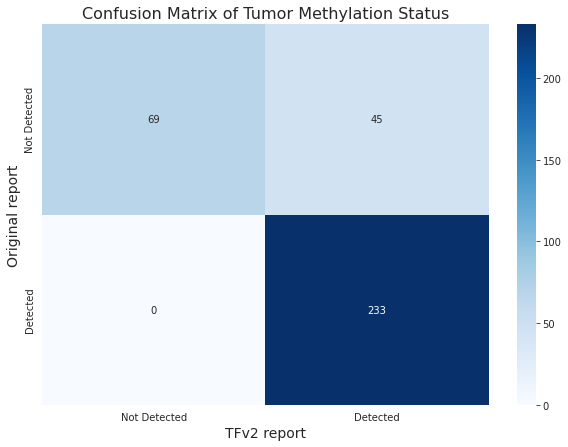

Cohen's Kappa: 0.67


In [45]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0
map_status = {"Detected": 1, "Not Detected": 0}

# Map the 'Tumor_methylation_status' in both dataframes
df_sow176_2['Tumor_methylation_status_mapped'] = df_sow176_2['Tumor_methylation_status'].map(map_status)
df_sow176_final['Tumor_methylation_status_mapped'] = df_sow176_final['Tumor_methylation_status'].map(map_status)

# Merge the dataframes on GHSampleID to ensure matching entries
merged_df = pd.merge(df_sow176_2[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     df_sow176_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Filter out rows with NaN in either of the mapped status columns
valid_indices = merged_df['Tumor_methylation_status_mapped_2'].notna() & merged_df['Tumor_methylation_status_mapped_final'].notna()
y_true = merged_df[valid_indices]['Tumor_methylation_status_mapped_2'].values
y_pred = merged_df[valid_indices]['Tumor_methylation_status_mapped_final'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Original report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


# MSI/MLH1 distribution across TFv2

In [2]:
# Readin the updated data
df_sow176_updated = pd.read_csv(f"{work_dir}/df_sow176_updated.csv")

df_sow176_updated.head()

,Study_ID,Customer_SampleID,GHRequestID,GHSampleID,Patient_ID,Visit_name,Alt-NoAlt,Sample_status,Sample_comment,Variant_type,Indel_type,Gene,Chromosome,Position,Exon,Mut_aa,Mut_nt,Mut_cdna,Transcript,Percentage,Splice_effect,Somatic_status,Molecular_consequence,Fusion_chrom_b,Fusion_gene_b,Fusion_position_a,Fusion_position_b,Direction_a,Direction_b,Downstream_gene,Copy_number,CNV_type,COSMIC,dbSNP,ClinVar,ClinVarID,Functional_impact,Mutant_allele_status,Mol_count,Max_percentage,Alleletype,HRD_score,Tumor_methylation_status,Tumor_methylation_score,TMB_score,TMB_category,MSI_High,cfDNA_ng,Plasma_ml_input,Plasma_ml_remaining,Received_date,Bloodcoll_date,Reported_date,Cancertype,Practice_name,Physician_name,runid,fc_dir,MLH1_single_region_call_Sirius1_5,MLH1_single_region_methyl_score_Sirius1_5,MLH1_single_region_molecules_Sirius1_5,MLH1_single_region_file_path_Sirius1_5,MLH1_single_region_call_Sirius1_1_4,MLH1_single_region_methyl_score_Sirius1_1_4,MLH1_single_region_molecules_Sirius1_1_4,MLH1_single_region_file_path_Sirius1_1_4,msi_score,msi_status,sampleQC,MB_pancancer_score,pred_frac_force
0,D9311C00001,6602928172,A0978709,B00630247,E6009005,C1D1,1,SUCCESS,NaN,SNV,NaN,TERT,5,1294163.0,2.0,E280K,C>T,c.838G>A,NM_198253.3,56.72,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV57204773,rs199701877,Likely_benign,455106.0,NaN,NaN,1365.0,7.48,NaN,NaN,Detected,0.000014,NaN,Not evaluable,Not Detected,11.492,3.0,0.0,12/05/2023,05/28/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630247/B00630247/B00630247.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.single_region_call.report.hdr.tsv,2.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630247/B00630247.autoqc_sample_qc.hdr.tsv,-20.152555,0.000014
1,D9311C00001,6602928050,A0978708,B00630248,E6004010,C1D1,1,SUCCESS,NaN,SNV,NaN,IGF2R,6,160450647.0,7.0,A281V,C>T,c.842C>T,NM_000876.4,56.07,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COSV63627392,rs919932123,NaN,NaN,NaN,NaN,3102.0,6.08,NaN,NaN,Detected,0.059198,9.45,Low,Not Detected,19.344,3.0,0.0,12/05/2023,04/26/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B00630248/B00630248/B00630248.single_region_call.hdr.tsv,0.0,0.000000,0.0,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.single_region_call.report.hdr.tsv,6.0,MSS/MSI-L,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036/B00630248/B00630248.autoqc_sample_qc.hdr.tsv,0.430251,0.059198
2,D9311C00001,6602533811,A0978705,B00630249,E6005004,C1D1,1,SUCCESS,NaN,SNV,NaN,NSD1,5,176722419.0,23.0,A2684T,G>A,c.8050G>A,NM_022455.5,53.56,NaN,germline,missense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs188326949,Likely_benign,369803.0,NaN,NaN,1043.0,0.48,NaN,NaN,Detected,0.000062,NaN,Not evaluable,Not Detected,8.320,3.0,0.0,12/05/2023,04/14/2021,05/23/2024,Endometrial Cancer,Not Applicable,Not Applicable,240325_A00569_0753_BHWHWLDSX7,/ghsfa/ivd/flowcentral/240325_A00569_0753_BHWHWLDSX7.2be9c857-c977-49cd-9bd2-53bda88ec443.20240327155036,0.0,0.0,0.0,/ghsfa/projects/pharma/projects/sirius_pharma/hazhang_projects/AZ_SOW176_MLH1_PM_08212024/MB_module_SOW176_single_region_output/B0063024

In [3]:
df_sow176_updated.msi_status.value_counts()

MSS/MSI-L    295
MSI-H         52
Name: msi_status, dtype: int64

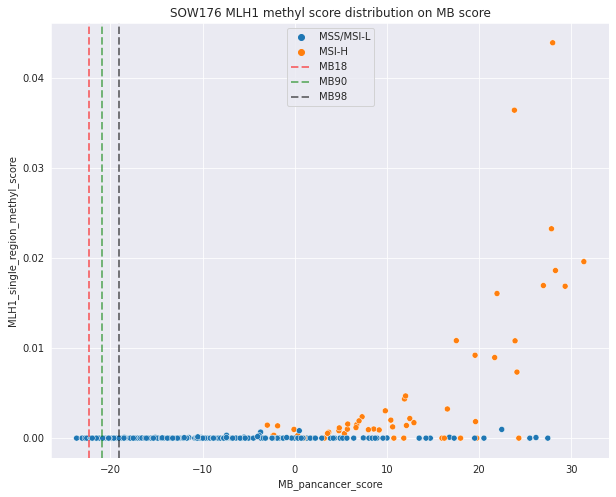

In [27]:
# Plot the MSI distribution on MB score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='MB_pancancer_score', y='MLH1_single_region_methyl_score', 
                hue='msi_status')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')
plt.axvline(x=-19.0509, color='black', linestyle='--', linewidth=2, alpha=0.5, label='MB98')


plt.title('SOW176 MLH1 methyl score distribution on MB score')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper center')



### MLH1 PM check

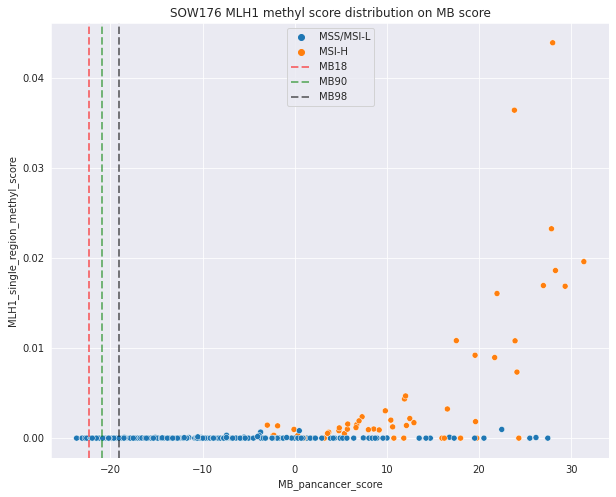

In [17]:
# Plot the MSI distribution on MB score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='MB_pancancer_score', y='MLH1_single_region_methyl_score', 
                hue='msi_status')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')
plt.axvline(x=-19.0509, color='black', linestyle='--', linewidth=2, alpha=0.5, label='MB98')


plt.title('SOW176 MLH1 methyl score distribution on MB score')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper center')



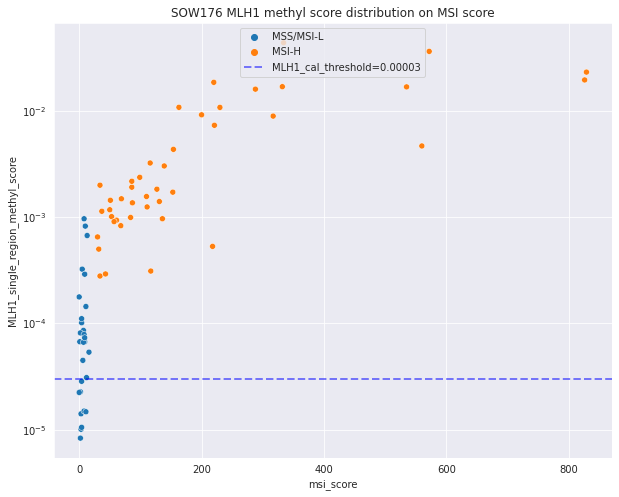

In [28]:
# Plot the MLH1 methyl score distribution on MSI score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
                hue='msi_status')

# sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
#                 hue='MLH1_single_region_call')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
# plt.axvline(x=19, color='red', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')
# plt.axhline(y=0.0005, color='red', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')
# 

# # Horizontal line for MLH1 methyl cutoff
plt.axhline(y= 0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')
# plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 MLH1 methyl score distribution on MSI score')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')



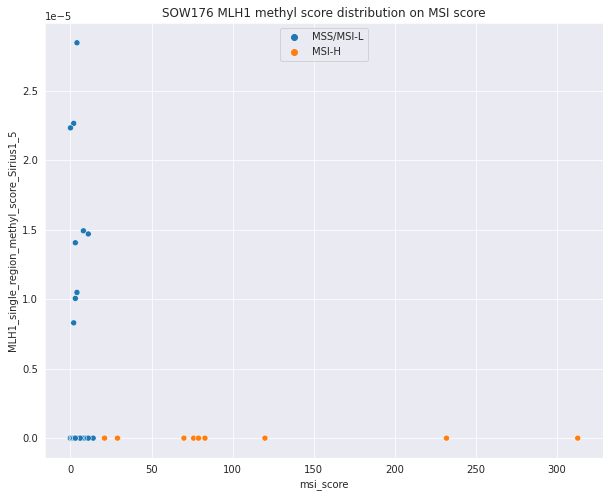

In [27]:
# Plot the MLH1 methyl score distribution on MSI score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=above_threshold, x='msi_score', y='MLH1_single_region_methyl_score_Sirius1_5', 
                hue='msi_status')

# sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
#                 hue='MLH1_single_region_call')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
# plt.axvline(x=19, color='red', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')
# plt.axhline(y=0.0005, color='red', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')
# 

# # Horizontal line for MLH1 methyl cutoff
# plt.axhline(y= 0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')
# plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 MLH1 methyl score distribution on MSI score')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper center')



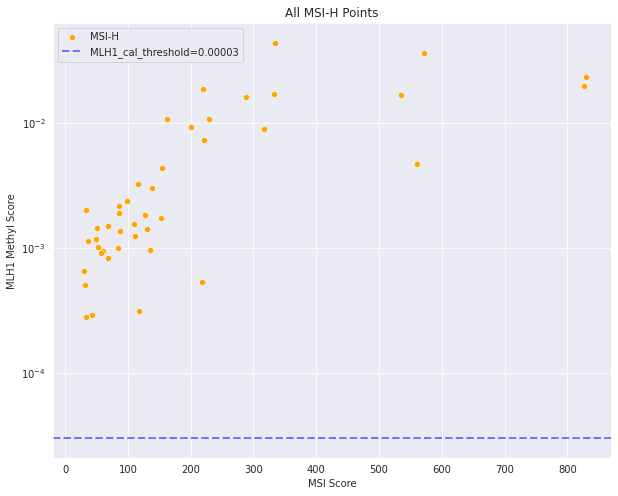

In [39]:


# Plotting all MSI-H points
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_sow176_updated[df_sow176_updated['msi_status'] == 'MSI-H'], x='msi_score', y='MLH1_single_region_methyl_score', color='orange', label='MSI-H')
plt.axhline(y=0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')
plt.yscale('log')
plt.title('All MSI-H Points')
plt.xlabel('MSI Score')
plt.ylabel('MLH1 Methyl Score')
plt.legend()
plt.show()


In [37]:
# Check the count of MSI-H samples with MLH1_single_region_call not equal to 1
msi_h_other_calls = df_sow176_updated[(df_sow176_updated['msi_status'] == 'MSI-H') & (df_sow176_updated['MLH1_single_region_call'] != 1)]
print("Number of MSI-H samples with MLH1_single_region_call not equal to 1:", msi_h_other_calls.shape[0])


Number of MSI-H samples with MLH1_single_region_call not equal to 1: 9


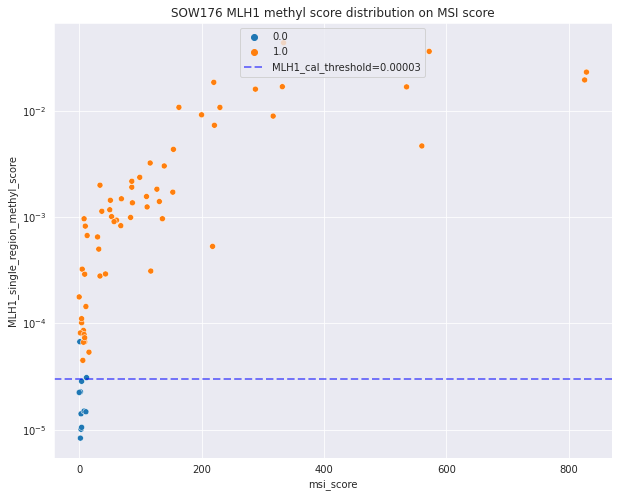

In [36]:
# Plot the MLH1 methyl score distribution on MSI score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
# sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
#                 hue='msi_status')

sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
                hue='MLH1_single_region_call')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
# plt.axvline(x=19, color='red', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')
# plt.axhline(y=0.0005, color='red', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')
# 

# # Horizontal line for MLH1 methyl cutoff
plt.axhline(y= 0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')
# plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 MLH1 methyl score distribution on MSI score')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')



Dataframe shape: (347, 65)
Missing values in each column:
 Study_ID                             0
Customer_SampleID                    0
GHRequestID                          0
GHSampleID                           0
Patient_ID                           0
Visit_name                           0
Alt-NoAlt                            0
Sample_status                        0
Sample_comment                     340
Variant_type                         0
Indel_type                         347
Gene                                 0
Chromosome                           0
Position                             0
Exon                                 0
Mut_aa                               1
Mut_nt                               0
Mut_cdna                             0
Transcript                           0
Percentage                           0
Splice_effect                      340
Somatic_status                       0
Molecular_consequence                0
Fusion_chrom_b                     347
Fusio

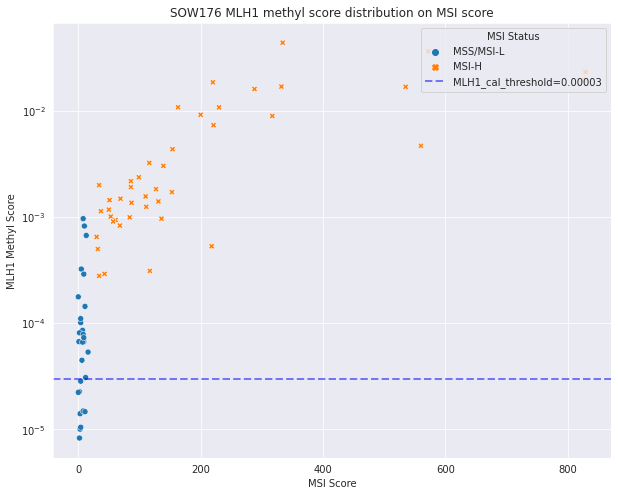

In [30]:
# Display the shape of the dataframe
print("Dataframe shape:", df_sow176_updated.shape)

# Check for any missing values
print("Missing values in each column:\n", df_sow176_updated.isna().sum())

# Plotting
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
scatter_plot = sns.scatterplot(data=df_sow176_updated, x='msi_score', y='MLH1_single_region_methyl_score', 
                               hue='msi_status', style='msi_status')

# Horizontal line for MLH1 methyl cutoff
plt.axhline(y=0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')

# Setting the scale to log for better visibility of data distribution
plt.yscale('log')

# Adding titles and labels
plt.title('SOW176 MLH1 methyl score distribution on MSI score')
plt.xlabel('MSI Score')
plt.ylabel('MLH1 Methyl Score')
plt.legend(title='MSI Status', loc='upper right')

# Show the plot
plt.show()

In [35]:
unique_msi_scores = df_sow176_updated['msi_score'].nunique()
print("Unique MSI Scores:", unique_msi_scores)

Unique MSI Scores: 66


In [40]:
# Filtering data points above the threshold line
threshold = 0.00003
above_threshold = df_sow176_updated[df_sow176_updated['MLH1_single_region_methyl_score'] > threshold]

# Counting the number of MSI-H and MSI-L samples above the threshold
msi_h_above = above_threshold[above_threshold['msi_status'] == 'MSI-H']
msi_l_above = above_threshold[above_threshold['msi_status'] == 'MSS/MSI-L']

print("MSI-H samples above threshold:", msi_h_above.shape[0])
print("MSI-L samples above threshold:", msi_l_above.shape[0])


MSI-H samples above threshold: 43
MSI-L samples above threshold: 19


In [41]:
df_sow176_updated.msi_status.value_counts()

MSS/MSI-L    295
MSI-H         52
Name: msi_status, dtype: int64

In [22]:
# Filtering data points above the threshold line
threshold = 0.00003
above_threshold = df_sow176_updated[df_sow176_updated['MLH1_single_region_methyl_score_Sirius1_5'] <= threshold]

# Counting the number of MSI-H and MSI-L samples above the threshold
msi_h_above = above_threshold[above_threshold['msi_status'] == 'MSI-H']
msi_l_above = above_threshold[above_threshold['msi_status'] == 'MSS/MSI-L']

print("MSI-H samples above threshold:", msi_h_above.shape[0])
print("MSI-L samples above threshold:", msi_l_above.shape[0])

MSI-H samples above threshold: 9
MSI-L samples above threshold: 276


In [44]:
msi_h_above.MLH1_single_region_methyl_score.value_counts()

0.0    9
Name: MLH1_single_region_methyl_score, dtype: int64

In [24]:
df_sow176_updated_MSI_H_MLH1_1 = df_sow176_updated[(df_sow176_updated['msi_status'] == 'MSI-H') & (df_sow176_updated['MLH1_single_region_call'] == 1)]
df_sow176_updated_MSI_H_MLH1_1.shape

(43, 65)

In [59]:
df_sow176_updated_MSI_H_MLH1_0.shape

(9, 65)

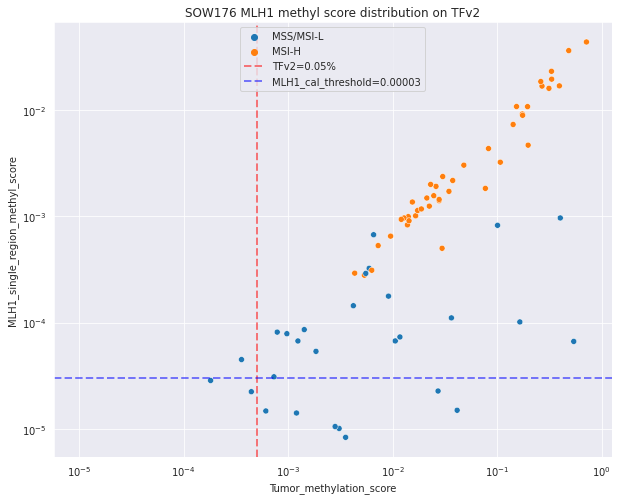

In [86]:
# Plot the MSI distribution on TFv2 score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='Tumor_methylation_score', y='MLH1_single_region_methyl_score', 
                hue='msi_status')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=0.0005, color='red', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


# # Horizontal line for msi_score = 19
plt.axhline(y= 0.00003, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='MLH1_cal_threshold=0.00003')


plt.title('SOW176 MLH1 methyl score distribution on TFv2')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper center')



In [82]:
# Readin the original report with MLH1 promoter methylation info
df_sow176_all_col = pd.read_csv(f"{work_dir}/20240523_AZN_SOW176_01_all_cols.csv", header = 1)
df_sow176_all_col.head()

# Filter for MLH detected samples in the original report
df_sow176_MLH1_detected = df_sow176_all_col[(df_sow176_all_col['Variant_type'] == "PromoterMethylation") & (df_sow176_all_col['Gene'] == "MLH1")]
df_sow176_MLH1_detected = df_sow176_MLH1_detected.drop_duplicates(subset= "GHSampleID")
df_sow176_MLH1_detected.shape

# Greate a new column to label Sirius 1.1.4 MLH call on MLH1
original_MLH1_positive_samples_sample_ids = df_sow176_MLH1_detected['GHSampleID'].unique()

df_sow176_updated['MLH1_single_region_call_original'] = np.where(
    (df_sow176_updated['GHSampleID'].isin(original_MLH1_positive_samples_sample_ids)), 1, 0)

df_sow176_updated.MLH1_single_region_call_original.value_counts()

0    280
1     67
Name: MLH1_single_region_call_original, dtype: int64

In [76]:
df_sow176_updated.MLH1_single_region_call.value_counts()

0.0    287
1.0     60
Name: MLH1_single_region_call, dtype: int64

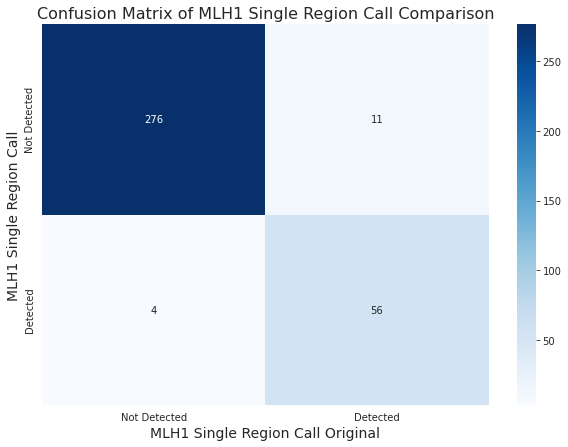

Cohen's Kappa: 0.86


In [84]:
# Compare the Sirius 1.1.4 vs Sirius 1.5

# Generating the confusion matrix directly since both columns are in the same dataframe
cm = confusion_matrix(df_sow176_updated['MLH1_single_region_call'], df_sow176_updated['MLH1_single_region_call_original'], labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('MLH1 Single Region Call Original', fontsize=14)
plt.ylabel('MLH1 Single Region Call', fontsize=14)
plt.title('Confusion Matrix of MLH1 Single Region Call Comparison', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(df_sow176_updated['MLH1_single_region_call'], df_sow176_updated['MLH1_single_region_call_original'])
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
df_sow176_updated_plot = df_sow176_updated.copy()

# Mapping "Detected" to 1 and "Not Detected" to 0
map_status = {"Detected": 1, "Not Detected": 0}

# Map the 'Tumor_methylation_status' in both dataframes
df_sow176_2['Tumor_methylation_status_mapped'] = df_sow176_2['Tumor_methylation_status'].map(map_status)
df_sow176_final['Tumor_methylation_status_mapped'] = df_sow176_final['Tumor_methylation_status'].map(map_status)

# Merge the dataframes on GHSampleID to ensure matching entries
merged_df = pd.merge(df_sow176_2[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     df_sow176_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Filter out rows with NaN in either of the mapped status columns
valid_indices = merged_df['Tumor_methylation_status_mapped_2'].notna() & merged_df['Tumor_methylation_status_mapped_final'].notna()
y_true = merged_df[valid_indices]['Tumor_methylation_status_mapped_2'].values
y_pred = merged_df[valid_indices]['Tumor_methylation_status_mapped_final'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Original report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


### MSI check

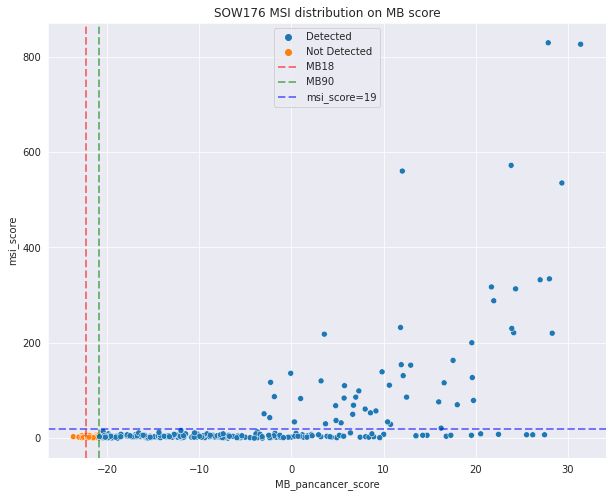

In [16]:
# Plot the MSI distribution on MB score

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='MB_pancancer_score', y='msi_score', 
                hue='Tumor_methylation_status')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')

# Horizontal line for msi_score = 19
plt.axhline(y=19, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')


plt.title('SOW176 MSI distribution on MB score')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper center')



In [17]:
df_sow176_updated.MSI_High.value_counts()

Not Detected    296
Detected         51
Name: MSI_High, dtype: int64

In [18]:
df_sow176_updated.shape

(347, 64)

In [108]:
df_sow176_updated.Tumor_methylation_status.value_counts()

Detected        278
Not Detected     69
Name: Tumor_methylation_status, dtype: int64

In [109]:
df_sow176_updated_neg = df_sow176_updated[df_sow176_updated['Tumor_methylation_status'] == 'Not Detected']

In [110]:
df_sow176_updated_neg.shape

(69, 64)

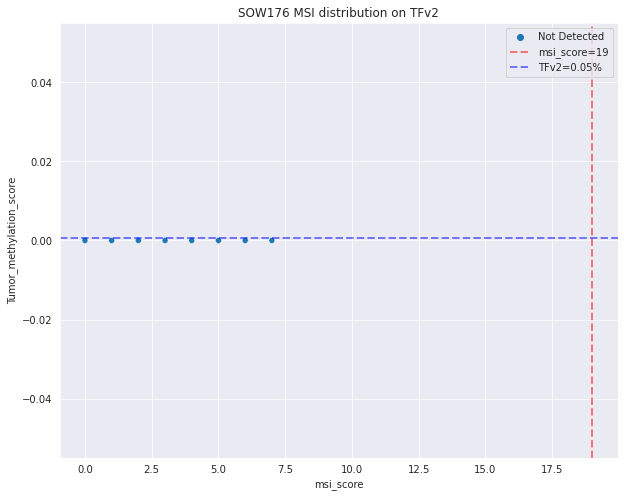

In [111]:
# Plot the MSI distribution on TFv2

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated_neg, x='msi_score', y='Tumor_methylation_score', hue='Tumor_methylation_status')

# Vertical lines for msi_score = 19
plt.axvline(x=19, color='red', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')
# plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')

# plt.ylim(-0.1, 0.7)

plt.title('SOW176 MSI distribution on TFv2')
# plt.xscale('log')
# plt.yscale('log')
plt.legend(loc='upper right')



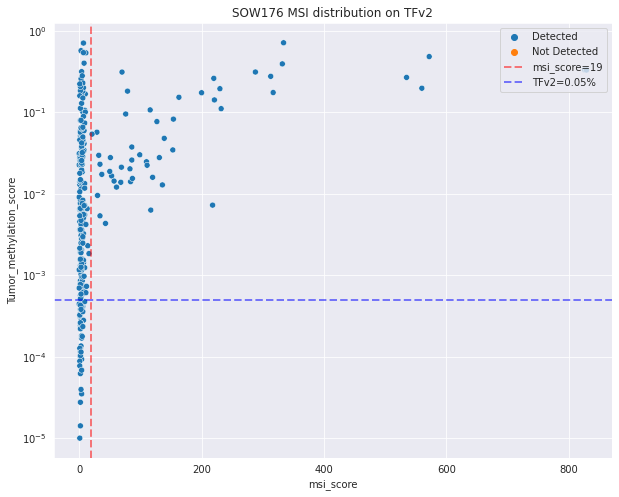

In [112]:
# Plot the MSI distribution on TFv2

plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_sow176_updated, x='msi_score', y='Tumor_methylation_score', hue='Tumor_methylation_status')

# Vertical lines for msi_score = 19
plt.axvline(x=19, color='red', linestyle='--', linewidth=2, alpha=0.5, label='msi_score=19')
# plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')

# plt.ylim(-0.1, 0.7)

plt.title('SOW176 MSI distribution on TFv2')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')



In [ ]:
# Check the distribution of Visit_name for the flipped positive calls
df_visit = pd.merge(df_sow176_2[['GHSampleID', 'Tumor_methylation_status_mapped', 'Visit_name']],
                     df_sow176_final[['GHSampleID', 'Tumor_methylation_status_mapped']],
                     on='GHSampleID', suffixes=('_2', '_final'))

# Create a mask for the specific case where status flips from Not Detected to Detected
mask = (df_visit['Tumor_methylation_status_mapped_2'] == 0) & (df_visit['Tumor_methylation_status_mapped_final'] == 1)
flipped_positive_samples = df_visit[mask]

# Get the MB score on positive flipped sampels
flipped_positive_samples_sample_ids = flipped_positive_samples['GHSampleID'].unique()

# Filter df_kyle_interest to find rows where run_sample_id is not in merged_sample_ids
df_flipped_pos = df_sow176_updated[df_sow176_updated['GHSampleID'].isin(flipped_positive_samples_sample_ids)]

df_flipped_pos.Visit_name.value_counts()




C3D1    52
C7D1    48
C1D1    45
C9D1    33
Name: Visit_name, dtype: int64

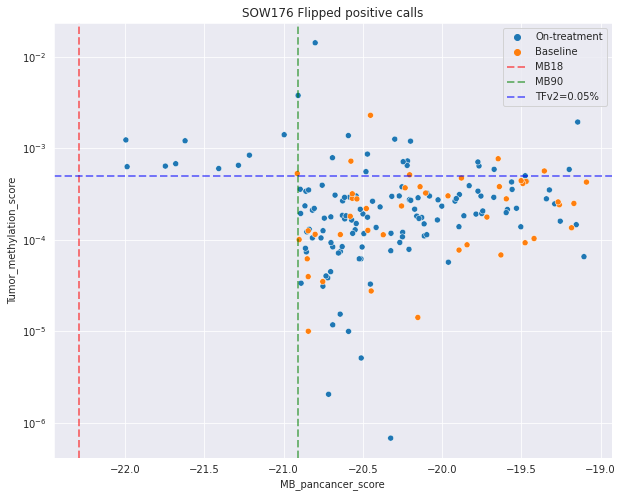

In [ ]:
# Plot the distribution

df_flipped_pos['Treatment'] = np.where(
    (df_flipped_pos['Visit_name'] == 'C1D1'),
    'Baseline',
    'On-treatment'
)
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

# Scatter plot
sns.scatterplot(data=df_flipped_pos, x='MB_pancancer_score', y='Tumor_methylation_score', 
                hue='Treatment')

# Vertical lines for MB18 and MB90 of pan-cancer (MB18: -22.289441; MB90: -20.907684)
plt.axvline(x=-22.289441, color='red', linestyle='--', linewidth=2, alpha=0.5, label='MB18')
plt.axvline(x=-20.907684, color='green', linestyle='--', linewidth=2, alpha=0.5, label='MB90')

# Horizontal line for Tumor_methylation_score = 0.0005
plt.axhline(y=0.0005, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='TFv2=0.05%')


plt.title('SOW176 Flipped positive calls')
# plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')



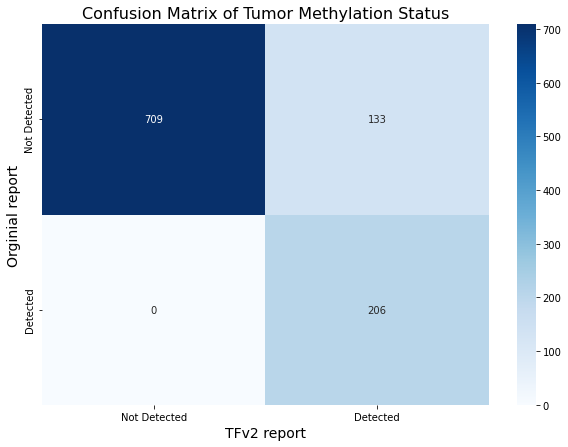

Cohen's Kappa: 0.68


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_monitoring_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_all['Tumor_methylation_status'].map(map_status)
df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] = df_sow176_monitoring_final_all['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_monitoring_all['Tumor_methylation_status_mapped'].notna() & df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_monitoring_all[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_monitoring_final_all[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
# Create a mask for the specific case
mask = (df_sow176_monitoring_all['Tumor_methylation_status_mapped'] == 0) & (df_sow176_monitoring_final_all['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_monitoring_final_all[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C3D1    52
C7D1    48
C9D1    33
Name: Visit_name, dtype: int64


In [ ]:
df_sow176_monitoring_final_all.Visit_name.value_counts()

C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [ ]:
# Remove duplication for infinity final
df_sow176_infinity_dedup = df_sow176_ori_1.drop_duplicates(subset = "GHSampleID")
df_sow176_infinity_final_dedup = df_sow176_infinity_final_all.drop_duplicates(subset = "GHSampleID")

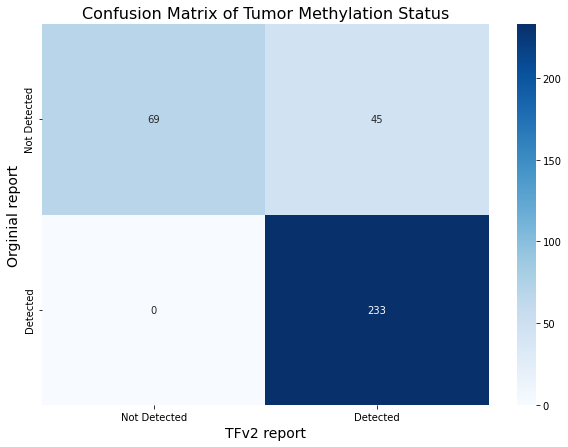

Cohen's Kappa: 0.67


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score

# Mapping "Detected" to 1 and "Not Detected" to 0, assume NaN remains as NaN
map_status = {"Detected": 1, "Not Detected": 0}

df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_dedup['Tumor_methylation_status'].map(map_status)
df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] = df_sow176_infinity_final_dedup['Tumor_methylation_status'].map(map_status)

# Remove NaN values before creating the confusion matrix
valid_indices = df_sow176_infinity_dedup['Tumor_methylation_status_mapped'].notna() & df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'].notna()
y_true = df_sow176_infinity_dedup[valid_indices]['Tumor_methylation_status_mapped'].values
y_pred = df_sow176_infinity_final_dedup[valid_indices]['Tumor_methylation_status_mapped'].values

# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Detected", "Detected"], yticklabels=["Not Detected", "Detected"])
plt.xlabel('TFv2 report', fontsize=14)
plt.ylabel('Orginial report', fontsize=14)
plt.title('Confusion Matrix of Tumor Methylation Status', fontsize=16)
plt.show()

# Calculating and printing Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.2f}")


In [ ]:
# Create a mask for the specific case
mask = (df_sow176_infinity_dedup['Tumor_methylation_status_mapped'] == 0) & (df_sow176_infinity_final_dedup['Tumor_methylation_status_mapped'] == 1)

# Filter the data using the mask
detected_not_detected = df_sow176_infinity_final_dedup[mask]

# Count the values of 'Visit_name' for these samples
visit_name_counts = detected_not_detected['Visit_name'].value_counts()

# Print the result
print(visit_name_counts)


C1D1    45
Name: Visit_name, dtype: int64


In [ ]:
df_sow176_final.Visit_name.value_counts()

C1D1    352
C9D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64

In [ ]:
df_sow176_2.Visit_name.value_counts()

C9D1    352
C1D1    352
C3D1    351
C7D1    351
Name: Visit_name, dtype: int64